In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 57.6 MB/s 
     |████████████████████████████████| 596 kB 67.9 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [12]:
import os

# For data manipulation
import numpy as np
import pandas as pd
import warnings
import pickle


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
import torch.nn as nn

# For Transformer Models
from transformers import (
    AdamW,
    AutoTokenizer, 
    pipeline,
    AutoModel,
    AutoConfig,
    AutoModelForSequenceClassification, 
    AutoModelForTokenClassification,
    DataCollatorForLanguageModeling, 
    get_scheduler,
    Trainer, 
    TrainingArguments
)

from tqdm.auto import tqdm

## Загрузка данных

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/skillfactory-hackaton-team9/twitter-analyzer/main/parsed_data/twitter_new_raw_data.csv", index_col=0)

In [4]:
df.head()

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4
2,2022-07-04T05:47:11.000Z,ленаelena,@elena53166542,У Хаматовой денег море. Она обокрал фонд Подар...,2,0,1
3,2022-07-02T19:22:11.000Z,Dre1,@DremanerDre1,"Мих, ты не ""Лёняверим"", может кто-либо из твои...",0,0,0
4,2022-07-01T18:44:57.000Z,"Wishmaster© Vendetta,",–,Дебиторская задолженность фонда «Подари жизнь»...,0,1,3


In [ ]:
df.shape

(2533, 7)

In [ ]:
def text2toxicity(text, aggregate=False):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba

## Предсказания первой модели

In [ ]:
MODEL_NAME = 'cointegrated/rubert-tiny-toxicity'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
if torch.cuda.is_available():
    model.cuda()

In [ ]:
df.text.head(10)

0    по оценке журнала «Forbes» Керимов стал третьи...
1    Хаматова в свой фонд подари жизнь по 1млрд в г...
2    У Хаматовой денег море. Она обокрал фонд Подар...
3    Мих, ты не "Лёняверим", может кто-либо из твои...
4    Дебиторская задолженность фонда «Подари жизнь»...
5    Антон с Димой, которые приехали  в фонд "подар...
6    антон и дима посетили фонд "подари жизнь"..\n\...
7    дима с антоном поддержавшие фонд «подари жизнь...
8    Антон и Дима поддерживающие фонд "подари жизнь...
9    она увидела новость и видео что шазовы приехал...
Name: text, dtype: object

In [ ]:
sentiment = df.text.apply(text2toxicity)

In [ ]:
sentiment_m1_df = pd.DataFrame.from_records(sentiment, columns=["m1_notoxic", "m1_insult", "m1_obscenity", "m1_threat", "m1_dangerous"])

In [ ]:
df.join(sentiment_m1_df)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,m1_threat,m1_dangerous
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0,0.999206,0.000774,0.000202,0.000292,0.437558
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4,0.969807,0.032301,0.001154,0.000317,0.736651
2,2022-07-04T05:47:11.000Z,ленаelena,@elena53166542,У Хаматовой денег море. Она обокрал фонд Подар...,2,0,1,0.999454,0.000700,0.000134,0.000142,0.263747
3,2022-07-02T19:22:11.000Z,Dre1,@DremanerDre1,"Мих, ты не ""Лёняверим"", может кто-либо из твои...",0,0,0,0.999337,0.000653,0.000186,0.000366,0.466459
4,2022-07-01T18:44:57.000Z,"Wishmaster© Vendetta,",–,Дебиторская задолженность фонда «Подари жизнь»...,0,1,3,0.998452,0.001748,0.000132,0.000115,0.279766
...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2017-05-06T18:48:19.000Z,Ирина Громова,@XxVk6kcJpKasbsc,"Злата Травянко 5 лет. Требуется лечение, Вы мо...",0,0,0,0.999830,0.000194,0.000127,0.000128,0.069039
2529,2017-05-06T16:03:59.000Z,Марина Петрова,@SzdhBqOCuMMmzu8,"Миша Суганов 10 лет. Требуется лечение, Вы мож...",0,0,0,0.999758,0.000268,0.000110,0.000143,0.215942
2530,2017-05-06T15:34:57.000Z,Мари Фирсова,@XijM3aUJrimvMXu,"Аделия Ахметшина 1 год. Требуется лечение, Вы ...",0,0,0,0.999854,0.000166,0.000121,0.000156,0.101451
2531,2017-05-06T15:33:39.000Z,Евгения Попова,@gvkKVdJlFz4BwHM,"Катя Богданова 13 лет. Требуется лечение, Вы м...",0,0,0,0.999681,0.000337,0.000141,0.000157,0.290025


In [ ]:
df.shape

(2533, 7)

## Вторая модель

In [ ]:
MODEL_NAME = 'SkolkovoInstitute/russian_toxicity_classifier'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
if torch.cuda.is_available():
    model.cuda()

In [ ]:
df.text.head(10).apply(text2toxicity)

0     [0.9617549, 0.06992281]
1      [0.9212466, 0.1355247]
2    [0.89812875, 0.15502767]
3     [0.16126138, 0.6975852]
4     [0.8802895, 0.17825463]
5     [0.9519729, 0.07804812]
6    [0.9818751, 0.026242357]
7    [0.12501732, 0.71712625]
8      [0.919049, 0.12858465]
9    [0.94666874, 0.09064583]
Name: text, dtype: object

In [ ]:
df.loc[9,"text"]

'она увидела новость и видео что шазовы приехали в фонд подари жизнь который помогает детям в борьбе с раком пересмотрела 3 раза и сидит в соплях наши парни такие хорошие у меня нет слов только слезы которые я глотаю прямо сейчас'

In [ ]:
sentiment2 = df.text.apply(text2toxicity)

In [ ]:
sentiment_m2_df = pd.DataFrame.from_records(sentiment2, columns=["m2_neutral", "m2_toxic",])

## Третья модель (определение эмоций)

In [ ]:
MODEL_NAME = 'cointegrated/rubert-tiny2-cedr-emotion-detection'

In [ ]:
labels = ["no_emotion", "joy", "sadness", "surprise", "fear", "anger"]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
if torch.cuda.is_available():
    model.cuda()

In [ ]:
df.text.head(10).apply(text2toxicity)

0    [0.99119663, 0.005001627, 0.005758982, 0.00485...
1    [0.014797394, 0.9686751, 0.009435466, 0.018443...
2    [0.9908999, 0.0041388078, 0.006805072, 0.00505...
3    [0.97956204, 0.007433666, 0.002904903, 0.00566...
4    [0.9907698, 0.0046692095, 0.00691416, 0.005395...
5    [0.98604786, 0.010197584, 0.0047300993, 0.0047...
6    [0.9684766, 0.01327445, 0.0036684093, 0.005364...
7    [0.33957234, 0.3033183, 0.007062518, 0.0021266...
8    [0.8579681, 0.19763982, 0.004242808, 0.0031628...
9    [0.0067128865, 0.069356784, 0.45901734, 0.0045...
Name: text, dtype: object

In [ ]:
df.loc[2,"text"]

'У Хаматовой денег море. Она обокрал фонд Подари жизнь. Там начались проверки, недостача миллиард, Потому и сбежала. Но надо сказать, что денег нет.'

In [ ]:
emotions3 = df.text.apply(text2toxicity)

In [ ]:
emotions_m3_df = pd.DataFrame.from_records(emotions3, columns=[f"m3_{label}" for label in labels])

## 4-ая модель 

In [ ]:
MODEL_NAME = 'Aniemore/rubert-tiny2-russian-emotion-detection'

In [ ]:
labels = ['neutral', 'happiness', 'sadness', 'enthusiasm', 'fear', 'anger', 'disgust']

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
if torch.cuda.is_available():
    model.cuda()

In [ ]:
emotions4 = df.text.apply(text2toxicity)

In [ ]:
emotions_m4_df = pd.DataFrame.from_records(emotions4, columns=[f"m4_{label}" for label in labels])

## Объединим результаты

In [ ]:
result_df = (
    df.join(sentiment_m1_df).
      join(sentiment_m2_df).
      join(emotions_m3_df).
      join(emotions_m4_df)
)

In [ ]:
result_df.head()

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m3_surprise,m3_fear,m3_anger,m4_neutral,m4_happiness,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0,0.999206,0.000774,0.000202,...,0.004857,0.005459,0.005077,0.987943,0.005911,0.007564,0.005373,0.005333,0.005620,0.003407
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4,0.969807,0.032301,0.001154,...,0.018444,0.004878,0.020253,0.043987,0.348249,0.180201,0.023196,0.002875,0.206812,0.010694
2,2022-07-04T05:47:11.000Z,ленаelena,@elena53166542,У Хаматовой денег море. Она обокрал фонд Подар...,2,0,1,0.999454,0.000700,0.000134,...,0.005050,0.005141,0.005481,0.982843,0.005219,0.011761,0.004467,0.005009,0.005505,0.003115
3,2022-07-02T19:22:11.000Z,Dre1,@DremanerDre1,"Мих, ты не ""Лёняверим"", может кто-либо из твои...",0,0,0,0.999337,0.000653,0.000186,...,0.005663,0.006284,0.011269,0.697096,0.006642,0.005628,0.087352,0.013222,0.145647,0.007568
4,2022-07-01T18:44:57.000Z,"Wishmaster© Vendetta,",–,Дебиторская задолженность фонда «Подари жизнь»...,0,1,3,0.998452,0.001748,0.000132,...,0.005395,0.004534,0.005451,0.985294,0.005397,0.008487,0.005297,0.004396,0.005548,0.003071


In [ ]:
result_df.shape

(2533, 27)

In [ ]:
result_df.to_csv("sentiment_from_4_models.csv")

In [ ]:
result_df.sort_values("m4_disgust", ascending=False).text.head().values

array(['пиздец я только сейчас узнала что «подари жизнь» которым столько прикрывали и прикрывают хаматову это даже не фонд хаматовой',
       '#allegri_pro Фонд "Подари жизнь" отстоял свое название в Верховном суде https://goo.gl/fb/iiUfrg',
       'С подачи И.В.Безруковой интернет разукрашен бредом обо мне и С.В.Безрукове, и опять же устами той, что всех детей предлагала травить зарином. Весёлая компания идиоток, учитывая, что фонд их Подари жизнь тоже для детей, но строящий хосписы для умирающих, а не больницы для лечения',
       '#ryazan Фонд «Подари жизнь» предупредил о мошенниках в соцсетях http://ow.ly/2tqMsV',
       'Всё-таки приняли закон об НКО. Блядство.\nПодари Жизнь,предлагаю всем нам скинуться на футболки а-ля "Фонд.Джеймс Фонд" или "Я агент нах!"..'],
      dtype=object)

## Определение объектов в тексте

In [ ]:
MODEL_NAME = 'KoichiYasuoka/bert-base-russian-upos'

In [ ]:
token_classifier = pipeline(
    "token-classification", model=MODEL_NAME, aggregation_strategy="simple"
)


In [ ]:
text = "Я ездил в Барселону"
res = token_classifier(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
[x["word"] for x in res if x["entity_group"] == "PROPN"]

['Барселону']

In [ ]:
def find_objects(text):
  res = token_classifier(text)
  objs = [x["word"] for x in res if x["entity_group"] == "PROPN"]
  objs = [x.lower() for x in objs]
  objs = list(set(objs))
  objs = " ".join(objs)
  return objs


In [ ]:
df.text.head(10).apply(find_objects)

0    керимов жизнь горчакова forbes россии фонд фон...
1                                             хаматова
2                                            хаматовой
3                                лёняверим спартак мих
4                     чулпан хаматовой эдвард чесноков
5                                          антон димой
6                                           антон дима
7                                                     
8                                           антон дима
9                                                     
Name: text, dtype: object

In [ ]:
series_ojbects = df.text.apply(find_objects)

## Объединим все в один набор

In [ ]:
result_df["m5_objects"] = series_ojbects

In [ ]:
result_df.head()

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m3_fear,m3_anger,m4_neutral,m4_happiness,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0,0.999206,0.000774,0.000202,...,0.005459,0.005077,0.987943,0.005911,0.007564,0.005373,0.005333,0.005620,0.003407,керимов жизнь горчакова forbes россии фонд фон...
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4,0.969807,0.032301,0.001154,...,0.004878,0.020253,0.043987,0.348249,0.180201,0.023196,0.002875,0.206812,0.010694,хаматова
2,2022-07-04T05:47:11.000Z,ленаelena,@elena53166542,У Хаматовой денег море. Она обокрал фонд Подар...,2,0,1,0.999454,0.000700,0.000134,...,0.005141,0.005481,0.982843,0.005219,0.011761,0.004467,0.005009,0.005505,0.003115,хаматовой
3,2022-07-02T19:22:11.000Z,Dre1,@DremanerDre1,"Мих, ты не ""Лёняверим"", может кто-либо из твои...",0,0,0,0.999337,0.000653,0.000186,...,0.006284,0.011269,0.697096,0.006642,0.005628,0.087352,0.013222,0.145647,0.007568,лёняверим спартак мих
4,2022-07-01T18:44:57.000Z,"Wishmaster© Vendetta,",–,Дебиторская задолженность фонда «Подари жизнь»...,0,1,3,0.998452,0.001748,0.000132,...,0.004534,0.005451,0.985294,0.005397,0.008487,0.005297,0.004396,0.005548,0.003071,чулпан хаматовой эдвард чесноков


In [ ]:
result_df.shape

(2533, 28)

In [ ]:
result_df.to_csv("sentiment_from_5_models.csv")

# Обучим модель определять тему

In [13]:
df_train = pd.read_csv("https://raw.githubusercontent.com/skillfactory-hackaton-team9/twitter-analyzer/main/parsed_data/labeled_tweets_for_training.csv")

In [16]:
df_train[["text", "sentiment"]]

,text,sentiment
0,#bap #baby Открыли четвертый благотворительный...,новости
1,Фонд выдвинут на премию мира?: Основательниц б...,позитивные упоминания
2,"Другие благотворительные фонды: ""Подари жизнь""...",позитивные упоминания
3,"Фонд Хабенского - около тысячи детишек, получи...",позитивные упоминания
4,Фонд перечислил средства для Алины Трофимовой ...,деятельность фонда
...,...,...
195,Дебиторская задолженность фонда «Подари жизнь»...,негативные упоминания
196,"Мих, ты не ""Лёняверим"", может кто-либо из твои...",позитивные упоминания
197,У Хаматовой денег море. Она обокрал фонд Подар...,негативные упоминания
198,Хаматова в свой фонд подари жизнь по 1млрд в г...,негативные упоминания


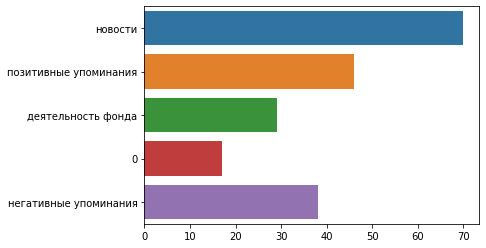

In [10]:
sns.countplot(data=df_train, y="sentiment", orient="h")
plt.xlabel("")
plt.ylabel("")
plt.show()

## Обучение модели

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
label_encoder = LabelEncoder()
df_train["label"] = label_encoder.fit_transform(df_train["sentiment"])

In [19]:
MODEL_NAME = "sberbank-ai/sbert_large_nlu_ru"
RANDOM_STATE = 42
MODEL_PATH = 'sb_model.h5'

BATCH_SIZE = 32
NUM_WORKERS = 2
MAX_LEN = 100
NUM_EPOCHS = 20

In [20]:
class Dataset:
    def __init__(self, text, target, tokenizer, max_len, num_labels):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        inputs = self.tokenizer(
            text, 
            max_length=self.max_len, 
            padding="max_length", 
            truncation=True
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(self.target[item], dtype=torch.long)
        }

In [21]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = Dataset(
    text=df_train.text.values, 
    target=df_train.label.values, 
    tokenizer=tokenizer, 
    max_len=MAX_LEN,
    num_labels=len(label_encoder.classes_)
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE
)


test_dataset = Dataset(
    text= df.text.values, 
    target=np.zeros(df.shape[0]),
    tokenizer=tokenizer, 
    max_len=MAX_LEN,
    num_labels=len(label_encoder.classes_)
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer);

## Обучим модель на тренировочном наборе

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
from transformers import get_scheduler

num_training_steps = NUM_EPOCHS * len(train_data_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

140


In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [26]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(NUM_EPOCHS):
    for batch in train_data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/140 [00:00<?, ?it/s]

In [27]:
model.eval()
result = []
for i,batch in enumerate(test_data_loader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    result.append(predictions)

In [28]:
predictions = torch.cat(result,0)

In [29]:
df["category"] = label_encoder.inverse_transform(predictions.cpu().numpy())

In [30]:
df[["text", "category"]].sample(20)

,text,category
574,"Фонд ""Подари жизнь"" начал проект развития клин...",новости
2088,Горбачев пообещал выдвинуть Чулпан Хаматову и ...,позитивные упоминания
1959,"Фонд ""Подари жизнь"" получит от властей участок...",новости
1701,"Фортов отдаст часть премии ""Глобальная энергия...",новости
268,А ещё монголы. Но без татар. Татары были хорош...,позитивные упоминания
2173,Детей под капельницами привезли на елку: Фонд ...,новости
2468,"Никита Убушаев 1 год. Требуется лечение, Вы мо...",деятельность фонда
741,Красноярский фонд «Подари жизнь» обязали смени...,негативные упоминания
389,Сейчас смотрю репетицию открытия Всемирных Дет...,новости
1328,"Чулпан Хаматова (фонд ""Подари жизнь"") Шаг Ввер...",0


In [31]:
df.to_csv("twitter_with_category.csv")

In [32]:
label_encoder.classes_

array(['0', 'деятельность фонда', 'негативные упоминания', 'новости',
       'позитивные упоминания'], dtype=object)